# 1. Setting Up Environment

In [4]:
# 1 Setting Up Environment
import isort
script_path = 'imports.py'
# Sorting the imports in the script
isort.file(script_path)
from imports import *
# For displaying plots inline
%matplotlib inline

# 2. Loading The Model & Preparing Data

In [5]:
def data_split(df, date_col, split_date):
    """
    Splits the given DataFrame into training and testing sets based on a split date.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'DATE' column for time-based splitting.
        date_col (str): The name of the column containing the date values.
        split_date (str): The date in 'YYYY-MM' format to split the data.
                         All rows before this date will be in the training set, and 
                         rows from this date onward will be in the test set.

    Returns:
        tuple: A tuple containing:
            - train_df (pd.DataFrame): DataFrame with rows before the split date.
            - test_df (pd.DataFrame): DataFrame with rows from the split date onward.
    """
    # Setting the DataFrame index to the date_col column for time-based slicing
    df.index = df[date_col]
    
    # Dropping the original 'DATE' column as it's now redundant
    df.drop(columns=[date_col], inplace=True)
    
    # Splitting the DataFrame into training and testing sets
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Selecting features representing diverse aspects of the data (e.g., liquidity, reserves, loans).
    # These features have been selected after thorough analysis and research has been performed, making sure to apply domain knowledge as well. 
    # These are also the features that the best model was trained on.
    selected_features = [
                         'GR_MAGNITUDE_NET_INTEREST_INCOME',
                         'GR_MAGNITUDE_EQUITY_TO_LOAN_RATIO', 
                         'GR_MAGNITUDE_RESERVE_SENSITIVITY', 
                         'GR_MAGNITUDE_LDR', 
                         'GR_MAGNITUDE_REAL_ESTATE_LOAN_RATIO', 
                         'GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO', 
                         'GR_MAGNITUDE_INTEREST_RATE', 
                         'GR_MAGNITUDE_DELINQUENCY_RATES_LOANS', 
                         'GR_MAGNITUDE_LOAN_CHARGE_OFF'
                         ] + ['STRESS_FLAG']
    train_df = train_df[selected_features]
    test_df = test_df[selected_features]
    
    return train_df, test_df


def fetch_model_and_events(data_path, model_path, date_col, split_date, target_col, v2, v1, v0):
    """
    Loads the preprocessed data and the trained model, splits the test data into 
    stress and non-stress events, and prepares them for evaluation.

    Args:
        data_path (str): The path to the preprocessed data file.
        model_path (str): The path to the saved model file.
        date_col (str): The name of the column containing the date values.
        split_date (str): The date in 'YYYY-MM' format to split the data.
                         All rows before this date will be in the training set, and 
                         rows from this date onward will be in the test set.
        target_col (str): The name of the target column containing stress flags.
        v2 (int): The original value in the target column representing stress events.
        v1 (int): The new value to represent stress events after consolidation.
        v0 (int): The value representing non-stress events in the target column.
    Returns:
        tuple: A tuple containing:
            - stress_events (pd.DataFrame): Subset of the test set where 'STRESS_FLAG' is 1.
            - non_stress_events (pd.DataFrame): Subset of the test set where 'STRESS_FLAG' is 0.
            - best_model: The trained model loaded from a saved file.
    """
    # Load the preprocessed data
    df = pd.read_csv(f'{data_path}.csv')
    
    # Consolidate stress flags into a binary representation (1 for stress, 0 for no stress)
    # If STRESS_FLAG is 2, convert it to 1
    df.loc[(df[target_col] == v2), target_col] = v1
    
    # Split the data into training and test sets based on the specified date
    # The split date is chosen to have the most recent systemic stress events that occured after the Covid-19 recession
    # The reason behind this is that the aim of this project is to test the model on various scenarios, and such scenarios need to be derived from recent systemic stress events
    # The Covid-19 recession period started in February 2020 and ended in April 2020, hence the split date would be May 2020.
    _, test_df = data_split(df, date_col, split_date)
    
    # Loading the trained model from a .pkl file
    best_model = load(f'{model_path}.pkl')
    
    # Splitting the test set into stress and non-stress events for separate analysis
    stress_events = test_df[test_df[target_col] == v1]  # Positive class (stress events)
    non_stress_events = test_df[test_df[target_col] == v0]  # Negative class (non-stress events)

    return stress_events, non_stress_events, best_model


# Fetching the stress and non-stress events along with the trained model
stress_events, non_stress_events, best_model = fetch_model_and_events(data_path='data_ready_for_model', 
                                                                      model_path='stress_best_model', 
                                                                      date_col='DATE', 
                                                                      split_date='2020-05', 
                                                                      target_col='STRESS_FLAG', 
                                                                      v2=2, 
                                                                      v1=1, 
                                                                      v0=0)

# 3. Generating Synthetic Data Using Monte Carlo Simulation

In [6]:
"""
Methodology:
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Simulation Method: 'Random Choice'
Primary Use: Replicates the real-world data distribution without assumptions.	
Insights Provided: Validates model performance under original conditions; acts as a baseline for comparison.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Simulation_method = 'Normal Distribution'
Primary Use: Models central tendency and variability, assuming most data is clustered around the mean.
Insights Provided: Evaluates model behavior under regular, stable conditions; highlights performance near average values.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Simulation_method = 'Exponential Distribution'
Primary Use: Models rare, extreme events with a rapid initial decline and long tail.
Insights Provided: Stress-tests the model's ability to handle outliers and rare, high-impact scenarios.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Focus:
    - The aim will be to try out different simulation methods by using the quantiles of each feature as thresholds, 
      and keep on evaluating the model's performance by going down the quantiles. This will show how the model performs and where it starts to fail.
"""

"\nMethodology:\n------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\nSimulation Method: 'Random Choice'\nPrimary Use: Replicates the real-world data distribution without assumptions.\t\nInsights Provided: Validates model performance under original conditions; acts as a baseline for comparison.\n------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\nSimulation_method = 'Normal Distribution'\nPrimary Use: Models central tendency and variability, assuming most data is clustered around the mean.\nInsights Provided: Evaluates model behavior under regular, stable conditions; highlights performance near average values.\n--------------------------------------------------------------------------------------------------------------------------------------

In [7]:
def apply_monte_carlo_simulation(target_col, 
                                 non_stress_stats, 
                                 stress_stats, 
                                 stress_events, 
                                 non_stress_events, 
                                 num_stress_samples, 
                                 num_non_stress_samples, 
                                 stress_value, 
                                 non_stress_value):
    """
    Apply Monte Carlo simulation to generate stress and non-stress scenarios.
    Parameters:
    target_col (str): The target column for which the stress and non-stress values are to be set.
    non_stress_stats (pd.DataFrame): DataFrame containing the mean and standard deviation of non-stress events.
    stress_stats (pd.DataFrame): DataFrame containing the mean and standard deviation of stress events.
    stress_events (pd.DataFrame): DataFrame containing the historical stress events.
    non_stress_events (pd.DataFrame): DataFrame containing the historical non-stress events.
    num_stress_samples (int): Number of stress samples to generate.
    num_non_stress_samples (int): Number of non-stress samples to generate.
    stress_value (float): The value to set for the target column in stress scenarios.
    non_stress_value (float): The value to set for the target column in non-stress scenarios.
    Returns:
    tuple: A tuple containing six DataFrames:
        - random_stress_simulated: Randomly simulated stress events.
        - random_non_stress_simulated: Randomly simulated non-stress events.
        - normal_dist_stress_simulated: Normally distributed simulated stress events.
        - normal_dist_non_stress_simulated: Normally distributed simulated non-stress events.
        - exp_dist_stress_simulated: Exponentially distributed simulated stress events with shifting for negative values.
        - exp_dist_non_stress_simulated: Exponentially distributed simulated non-stress events with shifting for negative values.
    """
    # Generating random samples for stress and non-stress events
    random_stress_simulated = pd.DataFrame({
        col: np.random.choice(stress_events[col], size=num_stress_samples, replace=True)
        for col in stress_events.columns if col != target_col
    })
    
    random_non_stress_simulated = pd.DataFrame({
        col: np.random.choice(non_stress_events[col], size=num_non_stress_samples, replace=True)
        for col in non_stress_events.columns if col != target_col
    })
    
    # Setting the target column values for the simulated data
    random_stress_simulated[target_col] = stress_value
    random_non_stress_simulated[target_col] = non_stress_value

    # Generating normally distributed samples for stress and non-stress events
    normal_dist_stress_simulated = pd.DataFrame({
        col: np.random.normal(stress_stats.loc['mean', col], stress_stats.loc['std', col], num_stress_samples)
        for col in stress_events.columns if col != target_col
    })
    
    normal_dist_non_stress_simulated = pd.DataFrame({
        col: np.random.normal(non_stress_stats.loc['mean', col], non_stress_stats.loc['std', col], num_non_stress_samples)
        for col in non_stress_events.columns if col != target_col
    })

    # Generating exponentially distributed samples with shifting for stress events
    exp_dist_stress_simulated = pd.DataFrame()
    for col in stress_events.columns:
        if col != target_col:
            shift_value = abs(stress_stats.loc['min', col]) + 1 if stress_stats.loc['min', col] < 0 else 0
            exp_dist_stress_simulated[col] = (
                np.random.exponential(stress_stats.loc['mean', col] + shift_value, num_stress_samples) - shift_value
            )

    # Generating exponentially distributed samples with shifting for non-stress events
    exp_dist_non_stress_simulated = pd.DataFrame()
    for col in non_stress_events.columns:
        if col != target_col:
            shift_value = abs(non_stress_stats.loc['min', col]) + 1 if non_stress_stats.loc['min', col] < 0 else 0
            exp_dist_non_stress_simulated[col] = (
                np.random.exponential(non_stress_stats.loc['mean', col] + shift_value, num_non_stress_samples) - shift_value
            )

    # Setting the target column values for the simulated data
    normal_dist_stress_simulated[target_col] = stress_value
    normal_dist_non_stress_simulated[target_col] = non_stress_value
    exp_dist_stress_simulated[target_col] = stress_value
    exp_dist_non_stress_simulated[target_col] = non_stress_value

    return (random_stress_simulated, random_non_stress_simulated, 
            normal_dist_stress_simulated, normal_dist_non_stress_simulated, 
            exp_dist_stress_simulated, exp_dist_non_stress_simulated)


In [8]:
def generate_synthetic_data(stress_events, non_stress_events, target_col, stress_value, non_stress_value, num_of_stress_samples, num_of_non_stress_samples):
    """
    Generates synthetic data using Monte Carlo simulation based on the provided stress and non-stress events.

    Args:
        stress_events (pd.DataFrame): DataFrame containing stress event data.
        non_stress_events (pd.DataFrame): DataFrame containing non-stress event data.
        target_col (str): Name of the target column indicating stress or non-stress.
        stress_value (int or float): Value representing stress events in the target column.
        non_stress_value (int or float): Value representing non-stress events in the target column.
        p1 (float): Proportion of stress events to generate (e.g., 0.7 for 70%).
        p2 (float): Proportion of non-stress events to generate (e.g., 0.3 for 30%).

    Returns:
        pd.DataFrame: DataFrame containing the generated synthetic data.
    """
    # Defining the number of samples for stress and non-stress events
    num_stress_samples = num_of_stress_samples
    num_non_stress_samples = num_of_non_stress_samples

    # Calculating statistics for stress event features
    stress_stats = stress_events.describe()

    # Calculating statistics for non-stress event features
    non_stress_stats = non_stress_events.describe()

    # Applying Monte Carlo simulation to generate synthetic data
    random_stress_simulated, random_non_stress_simulated, normal_dist_stress_simulated, normal_dist_non_stress_simulated, exp_dist_stress_simulated, exp_dist_non_stress_simulated = apply_monte_carlo_simulation(target_col, 
                                                                                                                                                                                                                 non_stress_stats, 
                                                                                                                                                                                                                 stress_stats, 
                                                                                                                                                                                                                 stress_events, 
                                                                                                                                                                                                                 non_stress_events, 
                                                                                                                                                                                                                 num_stress_samples, 
                                                                                                                                                                                                                 num_non_stress_samples, 
                                                                                                                                                                                                                 stress_value, 
                                                                                                                                                                                                                 non_stress_value)

    # Combining simulated stress and non-stress data
    random_simulated_data = pd.concat([random_stress_simulated, random_non_stress_simulated], ignore_index=True)
    normal_dist_simulated_data = pd.concat([normal_dist_stress_simulated, normal_dist_non_stress_simulated], ignore_index=True)
    exp_dist_simulated_data = pd.concat([exp_dist_stress_simulated, exp_dist_non_stress_simulated], ignore_index=True)
    
    return random_simulated_data, normal_dist_simulated_data, exp_dist_simulated_data

# Generating synthetic data based on the stress and non-stress events
random_simulated_data, normal_dist_simulated_data, exp_dist_simulated_data = generate_synthetic_data(stress_events, 
                                                                                                     non_stress_events, 
                                                                                                     target_col='STRESS_FLAG', 
                                                                                                     stress_value=1, 
                                                                                                     non_stress_value=0, 
                                                                                                     num_of_stress_samples=300,
                                                                                                     num_of_non_stress_samples=700)

# 4. Test Model

## 4.1 Randomly Simulated Events

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       700
           1       0.68      0.61      0.64       300

    accuracy                           0.80      1000
   macro avg       0.76      0.74      0.75      1000
weighted avg       0.79      0.80      0.79      1000



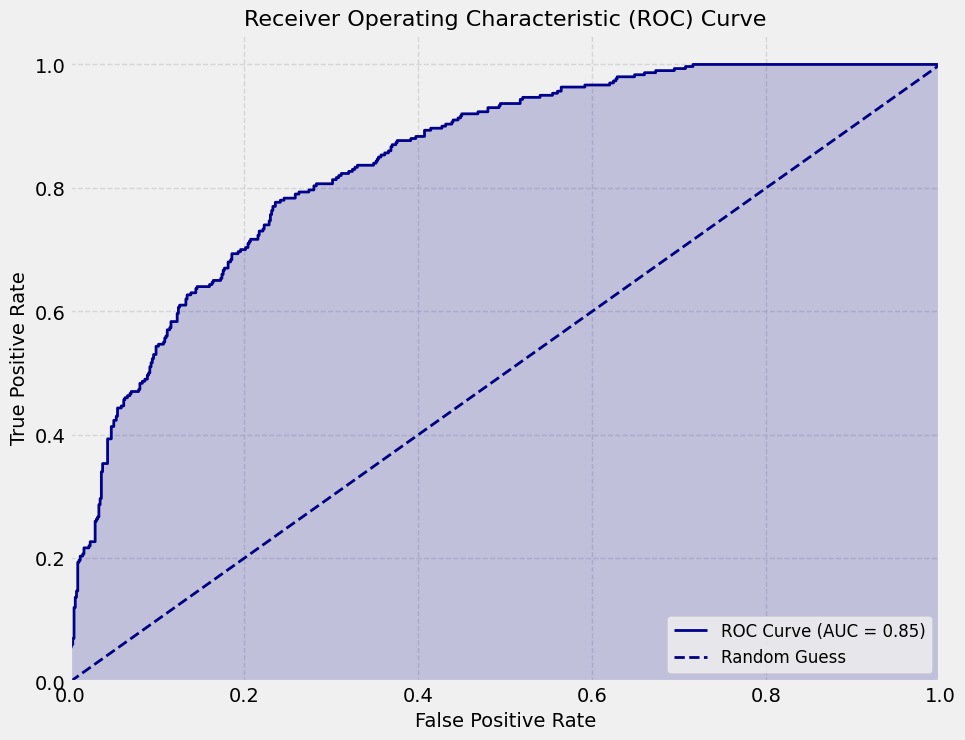

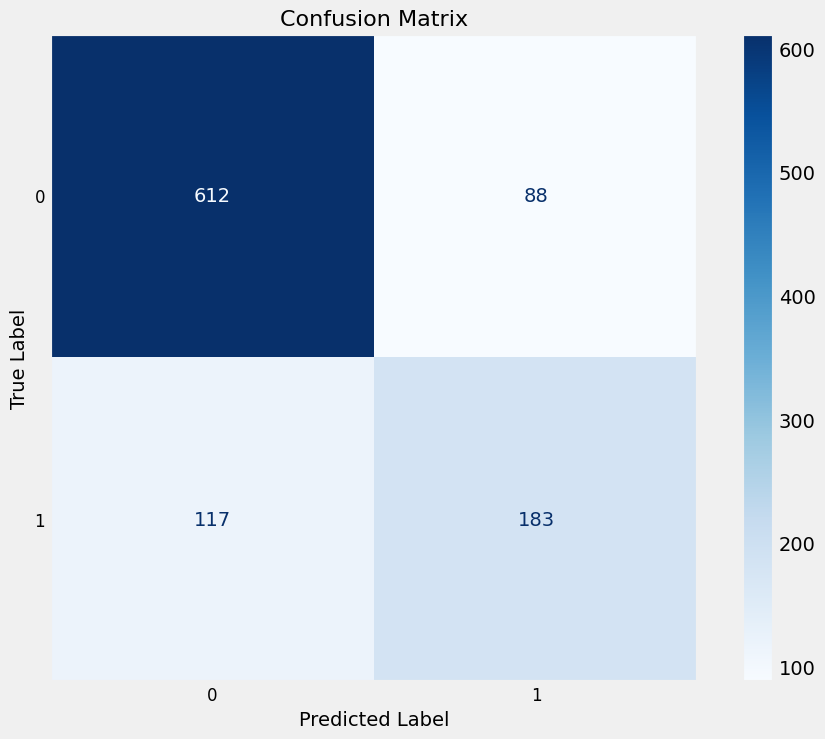

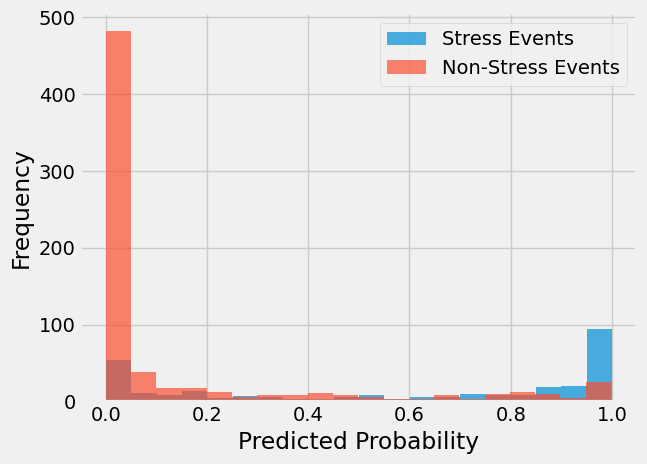

In [9]:
evaluation_functions.model_evaluation(random_simulated_data, best_model, 'STRESS_FLAG')

In [ ]:
'''
- The ROC AUC score of 0.82 indicates that the model has a strong ability to distinguish between stress and non-stress events.
- The overlap between 0.3 and 0.7 probabilities reflects ambiguity in distinguishing borderline cases, which impacts overall model performance.
- Very similar results to our initial test set.
'''

## 4.2 Normally Distributed Simulation

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       700
           1       0.57      0.69      0.63       300

    accuracy                           0.75      1000
   macro avg       0.71      0.73      0.72      1000
weighted avg       0.77      0.75      0.76      1000



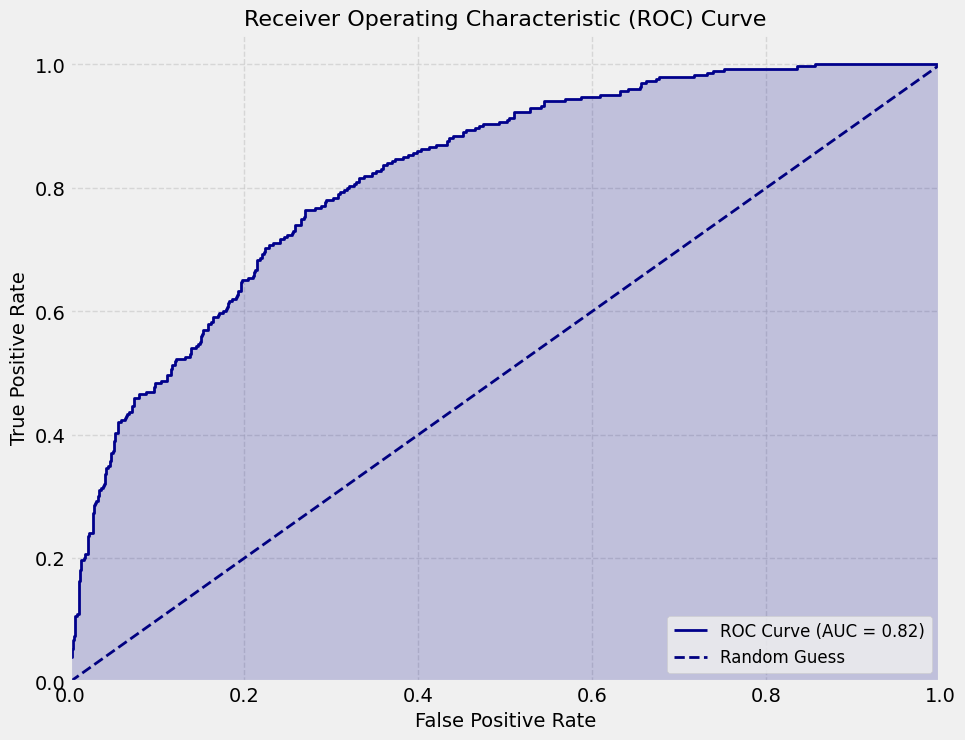

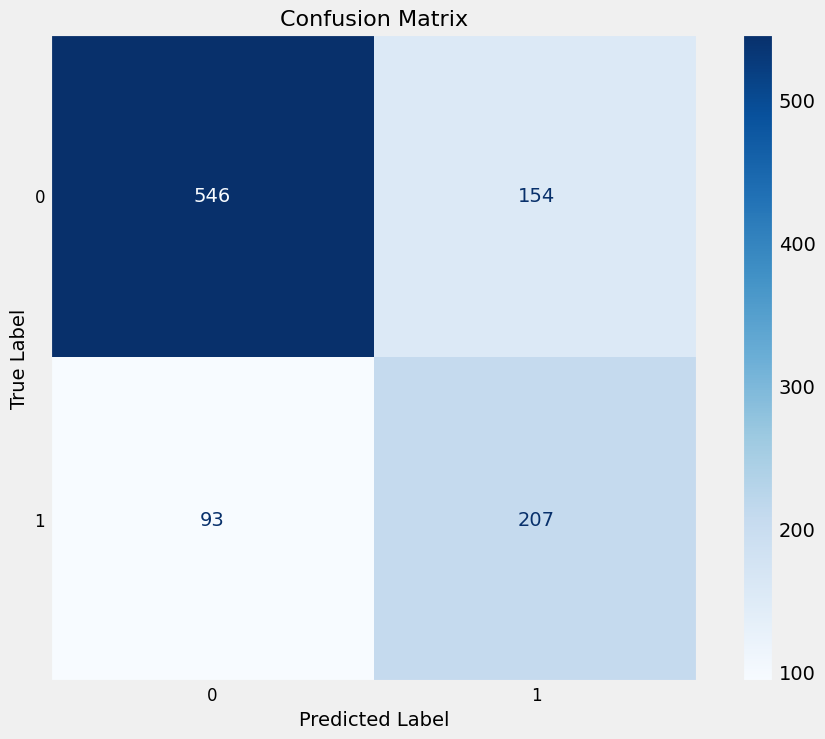

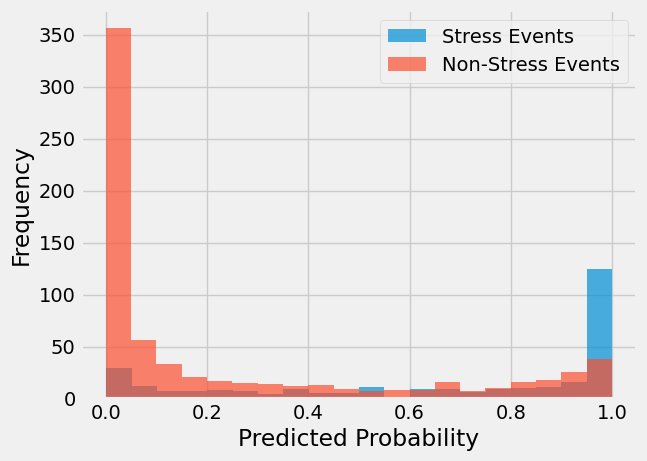

In [10]:
evaluation_functions.model_evaluation(normal_dist_simulated_data, best_model, 'STRESS_FLAG')

In [ ]:
'''
- The model successfully predicts stress events for a substantial portion of cases, contributing to moderate recall.
- Again, predictions in the 0.3 - 0.7 probability range exhibit significant overlap, indicating difficulty in distinguishing borderline cases.
- The AUC score of 0.84 shows that the model effectively differentiates between stress and non-stress events most of the time.
- The normal distribution simulation has a slightly better ROC AUC (0.84) compared to the random simulation (0.82), 
  indicating a marginal improvement in distinguishing between the two classes overall.
- Random simualtion seems to be more precise however normal distribution simulation seems to identify a larger portion of stress events (even at the cost of some false positives).
'''

## 4.3 Exponential Distribution Simulation

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       700
           1       0.44      0.53      0.48       300

    accuracy                           0.66      1000
   macro avg       0.61      0.62      0.61      1000
weighted avg       0.68      0.66      0.67      1000



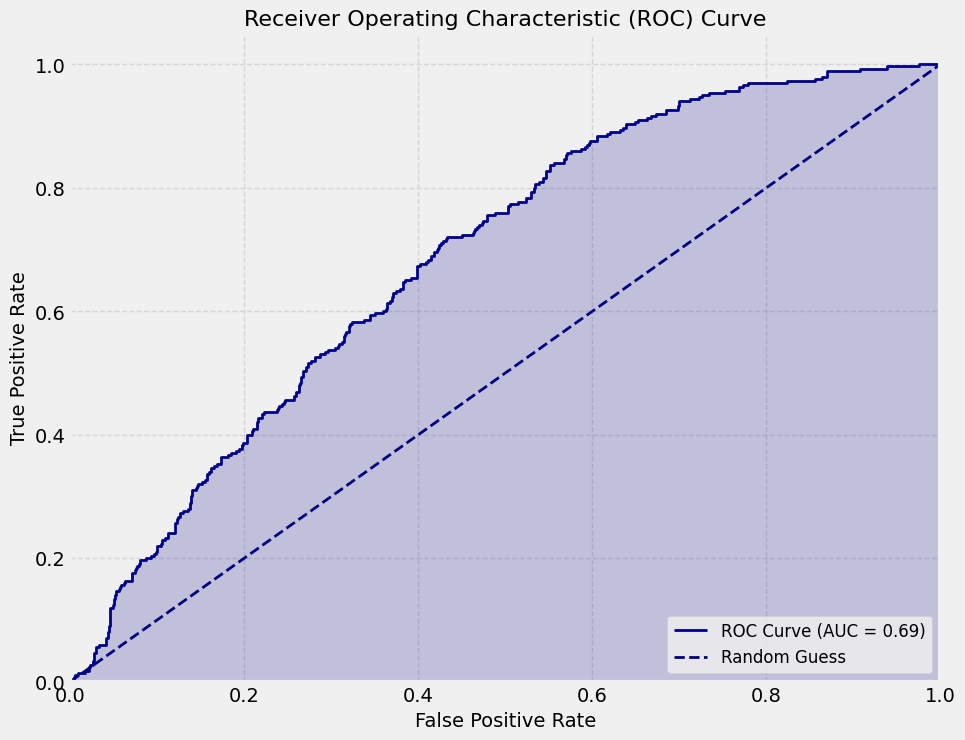

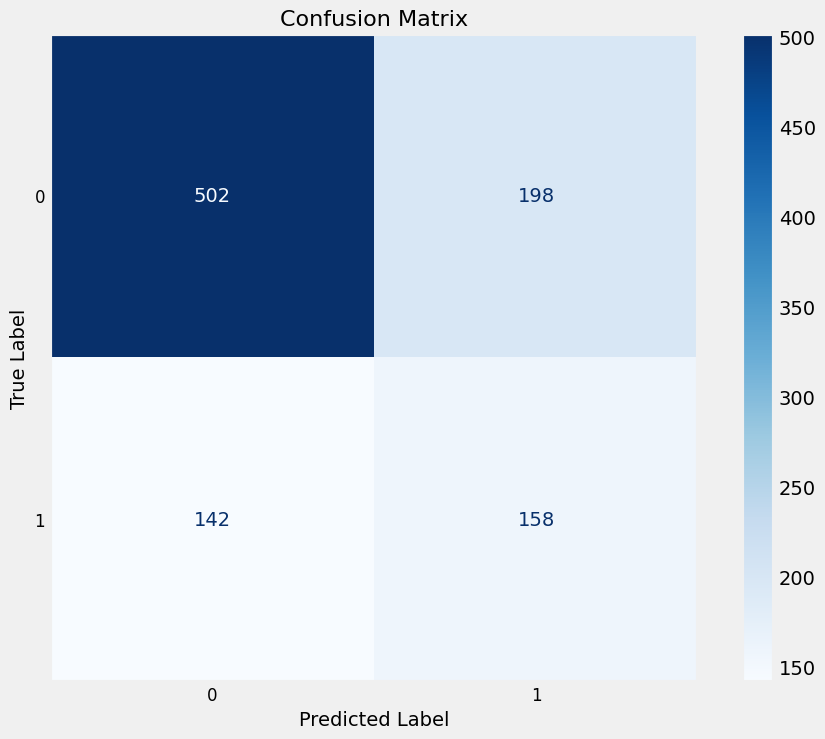

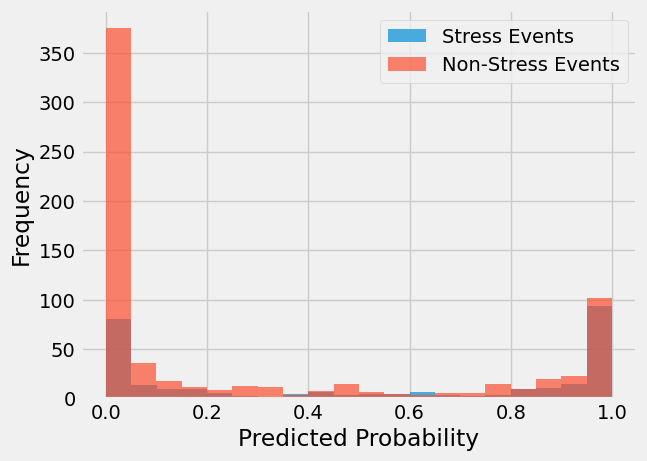

In [11]:
evaluation_functions.model_evaluation(exp_dist_simulated_data, best_model, 'STRESS_FLAG')

In [ ]:
'''
- Stress events are less concentrated in the high-probability range (close to 1), 
  and their distribution overlaps significantly with non-stress events in the mid-range (0.3 - 0.7), causing high misclassification rates.
- An AUC of 0.69 is the lowest among all simulations, indicating that the model has difficulty distinguishing between stress and non-stress events.
- The curve's proximity to the diagonal line highlights the weaker performance of the model compared to the random and normal distribution simulations.
- The question now is WHY?
    - The exponential distribution simulation performs the worst due to the skewed nature of the distribution, which introduces significant overlap and imbalance in the data.
    - Compared to the random and normal simulations, it struggles to achieve clear class separation, as evidenced by the low precision, recall, and ROC AUC.
    - This confirms once again our initial theory that the model struggles with borderline cases because:
      the model's struggle to distinguish borderline cases can indeed be explained by the overlap between stress and non-stress events in the feature space, 
      particularly when non-stress events exhibit extreme values that approach those of stress events.
        - If non-stress events occasionally have extreme feature values similar to stress events, the model will find it challenging to differentiate between the two classes.
        - In the case of the exponential distribution, the skewed nature of the data causes non-stress events to have a long tail. This tail overlaps with stress events, 
          creating ambiguity in borderline cases (e.g., probabilities in the 0.3-0.7 range).
        - The overlap reduces the separability of the two classes, 
          making the model more likely to misclassify non-stress events as stress events (false positives) and vice versa (false negatives).
        - The exponential distribution generates a large number of small values and a few extreme values. This creates a situation where borderline cases become more frequent, 
          especially when extreme values of non-stress events approach stress event values.
        - Frequency vs. Predicted Probability plot confirms this observation because:
            - Non-stress events should ideally cluster tightly near 0, but in this case, some extend into the higher probability range.
'''

## 4.4 Applying Various Scenarios

In [ ]:
def simulate_data_with_custom_thresholds(best_model,
                                         events, 
                                         top_features, 
                                         q_value, 
                                         sample_size, 
                                         target_col, 
                                         stress_value):
    """
    Evaluates the model on simulated data with custom thresholds for the top features.
    Args:
    stress_events: DataFrame containing stress event data.
    top_features: List of top features based on model importance.
    q_value: Quantile value for setting custom thresholds.
    sample_size: Number of samples to generate.
    target_col: Name of the target column indicating stress or non-stress.
    stress_value: Value representing stress events in the target column.
    Outputs:
    Prints the evaluation metrics for the simulated data.
    """
    events_w_custom_threshold = events.copy()
    
    for feature in top_features:
        
        events_w_custom_threshold[feature] = events[feature].quantile(q_value)
    
    stress_stats = events_w_custom_threshold.describe()
    
    np.random.seed(42)
    normal_dist_stress_simulated = pd.DataFrame({
        col: np.random.normal(stress_stats.loc['mean', col], stress_stats.loc['std', col], sample_size)
        for col in events_w_custom_threshold.columns if col != target_col
    })

    normal_dist_stress_simulated[target_col] = stress_value
    print(f"Quantile: {q_value}")
    evaluation_functions.model_accuracy(normal_dist_stress_simulated, best_model, target_col)

# Selecting TOP 5 features based on model's feature importance: 
# (The top 1, 2, 3, and 4 features were also selected earlier. As the number of features increases, 
# the model's accuracy decreases for lower thresholds in stress events and higher thresholds in non-stress events.).
top_features = ['GR_MAGNITUDE_DELINQUENCY_RATES_LOANS', 
                'GR_MAGNITUDE_RESERVE_SENSITIVITY', 
                'GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO', 
                'GR_MAGNITUDE_LDR', 
                'GR_MAGNITUDE_INTEREST_RATE', 
                ]

print("Evaluating Model Performance with Custom Thresholds for the Top Features in stress events")
# Simulating data with custom thresholds for the top features
quantiles = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
for q in quantiles:
    simulate_data_with_custom_thresholds(best_model,
                                         stress_events, 
                                         top_features, 
                                         q_value = q, 
                                         sample_size = 100, 
                                         target_col = 'STRESS_FLAG', 
                                         stress_value = 1)

print("-----------------------------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------")
print("Evaluating Model Performance with Custom Thresholds for the Top Features in non-stress events")
for q in quantiles:
    simulate_data_with_custom_thresholds(best_model,
                                         non_stress_events, 
                                         top_features, 
                                         q_value = q, 
                                         sample_size = 100, 
                                         target_col = 'STRESS_FLAG', 
                                         stress_value = 0)

Evaluating Model Performance with Custom Thresholds for the Top Features in stress events
Quantile: 0.9
Model Accuracy: 1.00
Quantile: 0.8
Model Accuracy: 1.00
Quantile: 0.7
Model Accuracy: 0.99
Quantile: 0.6
Model Accuracy: 0.99
Quantile: 0.5
Model Accuracy: 0.92
Quantile: 0.4
Model Accuracy: 0.99
Quantile: 0.3
Model Accuracy: 0.00
Quantile: 0.2
Model Accuracy: 0.02
Quantile: 0.1
Model Accuracy: 0.00
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
Evaluating Model Performance with Custom Thresholds for the Top Features in non-stress events
Quantile: 0.9
Model Accuracy: 0.02
Quantile: 0.8
Model Accuracy: 0.15
Quantile: 0.7
Model Accuracy: 1.00
Quantile: 0.6
Model Accuracy: 1.00
Quantile: 0.5
Model Accuracy: 1.00
Quantile: 0.4
Model Accuracy: 1.00
Quantile: 0.3
Model Accuracy: 1.00
Quantile: 0.2
Model Accuracy: 1.00
Quantile: 0.1
Mod

In [21]:
# Top 1 feature: 

top_features = ['GR_MAGNITUDE_DELINQUENCY_RATES_LOANS']

print("Evaluating Model Performance with Custom Thresholds for the Top Features in stress events")
# Simulating data with custom thresholds for the top features
quantiles = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
for q in quantiles:
    simulate_data_with_custom_thresholds(best_model,
                                         stress_events, 
                                         top_features, 
                                         q_value = q, 
                                         sample_size = 100, 
                                         target_col = 'STRESS_FLAG', 
                                         stress_value = 1)

print("-----------------------------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------")
print("Evaluating Model Performance with Custom Thresholds for the Top Features in non-stress events")
for q in quantiles:
    simulate_data_with_custom_thresholds(best_model,
                                         non_stress_events, 
                                         top_features, 
                                         q_value = q, 
                                         sample_size = 100, 
                                         target_col = 'STRESS_FLAG', 
                                         stress_value = 0)

Evaluating Model Performance with Custom Thresholds for the Top Features in stress events
Quantile: 0.9
Model Accuracy: 0.85
Quantile: 0.8
Model Accuracy: 0.85
Quantile: 0.7
Model Accuracy: 0.81
Quantile: 0.6
Model Accuracy: 0.81
Quantile: 0.5
Model Accuracy: 0.84
Quantile: 0.4
Model Accuracy: 0.84
Quantile: 0.3
Model Accuracy: 0.56
Quantile: 0.2
Model Accuracy: 0.68
Quantile: 0.1
Model Accuracy: 0.53
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
Evaluating Model Performance with Custom Thresholds for the Top Features in non-stress events
Quantile: 0.9
Model Accuracy: 0.38
Quantile: 0.8
Model Accuracy: 0.72
Quantile: 0.7
Model Accuracy: 0.72
Quantile: 0.6
Model Accuracy: 0.72
Quantile: 0.5
Model Accuracy: 0.69
Quantile: 0.4
Model Accuracy: 0.69
Quantile: 0.3
Model Accuracy: 0.71
Quantile: 0.2
Model Accuracy: 0.97
Quantile: 0.1
Mod

In [22]:
'''
The question now arises: If we increase/decrease the values of the top 1 to 5 features, at which thresholds will the model start to fail?
- This has been tried out on both type of events, where the distribution of each feature was above or below a specific quantile 
  and the model's accuracy in predicted such event is printed.
  This was done iteratively, first we focused on the top 1, then top 2, and so on until top 5.
  The more features we restrict, the lower the accuracy score around the following thresholds: 
  --> 0.8 and 0.9 for non-stress events.
    - Meaning that when feature values get closer to the extreme, the model fails. This is of course a rare event, 
      where feature values will be extreme and the financial institution doesn't face a systemic stress event.
  --> 0.2 and 0.1 for stress events.
    - Same conclusion as the previous point, where the extreme low values result in model failure, however this is also a rare event, as for a systemic event to occur
      feature values need to be high (low depending on the feature).
  - The high accuracy in higher quantiles (opposing order of quantiles) for both stress and non-stress events shows 
    that top features in the higher range strongly influence the model's decision-making.
  - This separate testing of stress and non-stress events provides a clear view of how each class responds to different feature ranges.

'''

"\nThe question now arises: If we increase/decrease the values of the top 1 to 5 features, at which thresholds will the model start to fail?\n- This has been tried out on both type of events, where the distribution of each feature was above or below a specific quantile \n  and the model's accuracy in predicted such event is printed.\n  This was done iteratively, first we focused on the top 1, then top 2, and so on until top 5.\n  The more features we restrict, the lower the accuracy score around the following thresholds: \n  --> 0.8 and 0.9 for non-stress events.\n    - Meaning that when feature values get closer to the extreme, the model fails. This is of course a rare event, \n      where feature values will be extreme and the financial institution doesn't face a systemic stress event.\n  --> 0.2 and 0.1 for stress events.\n    - Same conclusion as the previous point, where the extreme low values result in model failure, however this is also a rare event, as for a systemic event to o